In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

I first read in my regular season results files and examine

In [11]:
m_detailed_results = pd.read_csv('../kaggle_data/men/MRegularSeasonDetailedResults.csv')
m_detailed_results['Side'] = 'Men'
w_detailed_results = pd.read_csv('../kaggle_data/women/WRegularSeasonDetailedResults.csv')
w_detailed_results['Side'] = 'Women'
detailed_results = pd.concat([m_detailed_results, w_detailed_results], ignore_index=True)

In [12]:
detailed_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Side
0,2003,10,1104,68,1328,62,N,0,27,58,...,16,22,10,22,8,18,9,2,20,Men
1,2003,10,1272,70,1393,63,N,0,26,62,...,9,20,20,25,7,12,8,6,16,Men
2,2003,11,1266,73,1437,61,N,0,24,58,...,14,23,31,22,9,12,2,5,23,Men
3,2003,11,1296,56,1457,50,N,0,18,38,...,8,15,17,20,9,19,4,3,23,Men
4,2003,11,1400,77,1208,71,N,0,30,61,...,17,27,21,15,12,10,7,1,14,Men


In [13]:
detailed_results['LLoc'] = detailed_results['WLoc'].apply(lambda x: 'A' if x == 'H' else ('H' if x == 'A' else 'N'))

winner_rows = detailed_results.copy()
loser_rows = detailed_results.copy()

for col in detailed_results.columns.tolist():
    if col[0] == 'W':
        stat = col[1:]
        winner_rows[stat] = winner_rows['W' + stat]
        winner_rows['Opp' + stat] = winner_rows['L' + stat]
        winner_rows['Win'] = 1
        loser_rows[stat] = loser_rows['L' + stat]
        loser_rows['Opp' + stat] = loser_rows['W' + stat]
        loser_rows['Win'] = 0

        winner_rows = winner_rows.drop(columns=['W' + stat, 'L' + stat])
        loser_rows = loser_rows.drop(columns=['W' + stat, 'L' + stat])

games_expanded_detailed = pd.concat([winner_rows, loser_rows], ignore_index=True)
games_expanded_detailed.columns

Index(['Season', 'DayNum', 'NumOT', 'Side', 'TeamID', 'OppTeamID', 'Win',
       'Score', 'OppScore', 'Loc', 'OppLoc', 'FGM', 'OppFGM', 'FGA', 'OppFGA',
       'FGM3', 'OppFGM3', 'FGA3', 'OppFGA3', 'FTM', 'OppFTM', 'FTA', 'OppFTA',
       'OR', 'OppOR', 'DR', 'OppDR', 'Ast', 'OppAst', 'TO', 'OppTO', 'Stl',
       'OppStl', 'Blk', 'OppBlk', 'PF', 'OppPF'],
      dtype='object')

In [14]:
games_expanded_detailed['Possessions'] = (games_expanded_detailed['FGA'] - games_expanded_detailed['OR'] + games_expanded_detailed['TO'] + 0.44 * games_expanded_detailed['FTA'])
games_expanded_detailed['OppPossessions'] = (games_expanded_detailed['OppFGA'] - games_expanded_detailed['OppOR'] + games_expanded_detailed['OppTO'] + 0.44 * games_expanded_detailed['OppFTA'])

In [15]:
def safe_divide(numerator, denominator):
    return np.where(denominator == 0, None, numerator / denominator)

for team, other in [("", "Opp"), ("Opp", "")]:
    # Percentages based on field goals, free throws, assists
    games_expanded_detailed[f"{team}FGPercent"]      = safe_divide(games_expanded_detailed[f"{team}FGM"],  games_expanded_detailed[f"{team}FGA"])
    games_expanded_detailed[f"{team}FG3Percent"]     = safe_divide(games_expanded_detailed[f"{team}FGM3"], games_expanded_detailed[f"{team}FGA3"])
    games_expanded_detailed[f"{team}FTPercent"]      = safe_divide(games_expanded_detailed[f"{team}FTM"],  games_expanded_detailed[f"{team}FTA"])
    games_expanded_detailed[f"{team}AstPercent"]     = safe_divide(games_expanded_detailed[f"{team}Ast"], games_expanded_detailed[f"{team}FGM"])
    games_expanded_detailed[f"{team}Att3Percent"]    = safe_divide(games_expanded_detailed[f"{team}FGA3"], games_expanded_detailed[f"{team}FGA"])

    # Offensive rebounding percentage (special case)
    or_denominator = games_expanded_detailed[f"{team}OR"] + games_expanded_detailed[f"{other}DR"]
    or_zero_check = (games_expanded_detailed[f"{team}OR"] == 0) & (games_expanded_detailed[f"{other}DR"] == 0)
    games_expanded_detailed[f"{team}ORPercent"] = np.where(or_zero_check, None, safe_divide(games_expanded_detailed[f"{team}OR"], or_denominator))

    # Possession-based metrics
    games_expanded_detailed[f"{team}PointsPerPoss"] = safe_divide(games_expanded_detailed[f"{team}Score"], games_expanded_detailed[f"{team}Possessions"])
    games_expanded_detailed[f"{team}TOPerPoss"]     = safe_divide(games_expanded_detailed[f"{team}TO"],    games_expanded_detailed[f"{team}Possessions"])
    games_expanded_detailed[f"{team}StlPerPoss"]    = safe_divide(games_expanded_detailed[f"{team}Stl"],   games_expanded_detailed[f"{other}Possessions"])
    games_expanded_detailed[f"{team}BlkPerPoss"]    = safe_divide(games_expanded_detailed[f"{team}Blk"],   games_expanded_detailed[f"{other}Possessions"])
    total_possessions = games_expanded_detailed[f"{team}Possessions"] + games_expanded_detailed[f"{other}Possessions"]
    games_expanded_detailed[f"{team}PFPerPoss"]     = safe_divide(games_expanded_detailed[f"{team}Stl"], total_possessions)

I ended up not using PointsPerPoss

In [16]:
games_expanded_detailed.to_csv("useful_metrics_end.csv", index=False)

In [17]:
games_expanded_detailed

,Season,DayNum,NumOT,Side,TeamID,OppTeamID,Win,Score,OppScore,Loc,...,OppFG3Percent,OppFTPercent,OppAstPercent,OppAtt3Percent,OppORPercent,OppPointsPerPoss,OppTOPerPoss,OppStlPerPoss,OppBlkPerPoss,OppPFPerPoss
0,2003,10,0,Men,1104,1328,1,68,62,N,...,0.2,0.727273,0.363636,0.188679,0.294118,0.877193,0.254669,0.120128,0.026695,0.061813
1,2003,10,0,Men,1272,1393,1,70,63,N,...,0.25,0.45,0.291667,0.358209,0.416667,0.929204,0.176991,0.117028,0.087771,0.058754
2,2003,11,0,Men,1266,1437,1,73,61,N,...,0.115385,0.608696,0.409091,0.356164,0.54386,0.951341,0.187149,0.031368,0.078419,0.01564
3,2003,11,0,Men,1296,1457,1,56,50,N,...,0.272727,0.533333,0.5,0.44898,0.472222,0.868056,0.329861,0.069396,0.052047,0.03471
4,2003,11,0,Men,1400,1208,1,77,71,N,...,0.375,0.62963,0.5,0.258065,0.488372,1.129135,0.159033,0.109856,0.015694,0.055292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401175,2025,131,0,Women,3413,3471,0,66,75,H,...,0.210526,0.678571,0.384615,0.306452,0.235294,0.969995,0.142266,0.080906,0.013484,0.039609
401176,2025,132,0,Women,3476,3192,0,49,66,A,...,0.142857,0.944444,0.478261,0.381818,0.3125,1.065891,0.145349,0.129534,0.016192,0.064683
401177,2025,132,0,Women,3119,3250,0,62,74,A,...,0.357143,0.882353,0.555556,0.311111,0.277778,1.184379,0.240077,0.096154,0.0,0.048046
401178,2025,132,0,Women,3125,3293,0,62,83,N,...,0.5,0.866667,0.75,0.518519,0.185185,1.209913,0.189504,0.028918,0.043378,0.014518


In [18]:
to_make_graphs = games_expanded_detailed.copy()

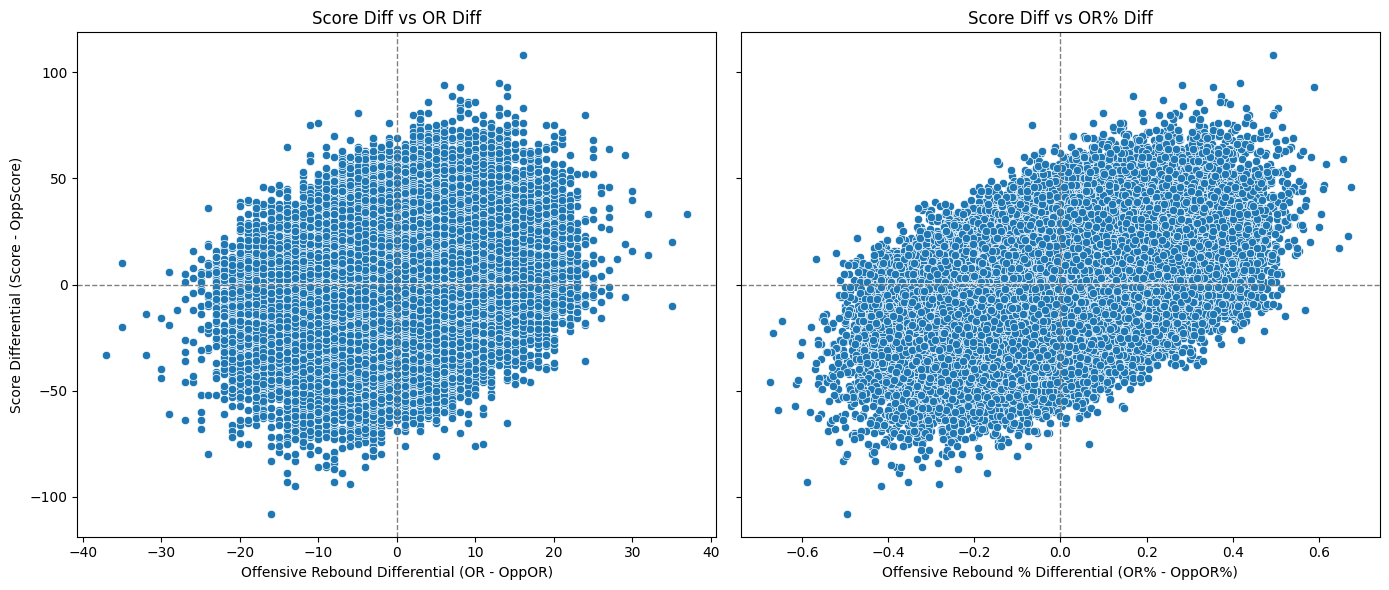

In [22]:
to_make_graphs['ScoreDiff'] = to_make_graphs['Score'] - to_make_graphs['OppScore']
to_make_graphs['ORDiff'] = to_make_graphs['OR'] - to_make_graphs['OppOR']
to_make_graphs['ORPercentDiff'] = to_make_graphs['ORPercent'] - to_make_graphs['OppORPercent']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: ORDiff vs ScoreDiff
sns.scatterplot(data=to_make_graphs, x='ORDiff', y='ScoreDiff', ax=axes[0])
axes[0].set_title('Score Diff vs OR Diff')
axes[0].set_xlabel('Offensive Rebound Differential (OR - OppOR)')
axes[0].set_ylabel('Score Differential (Score - OppScore)')
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0].axvline(0, color='gray', linestyle='--', linewidth=1)

# Plot 2: ORPercentDiff vs ScoreDiff
sns.scatterplot(data=to_make_graphs, x='ORPercentDiff', y='ScoreDiff', ax=axes[1])
axes[1].set_title('Score Diff vs OR% Diff')
axes[1].set_xlabel('Offensive Rebound % Differential (OR% - OppOR%)')
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].axvline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

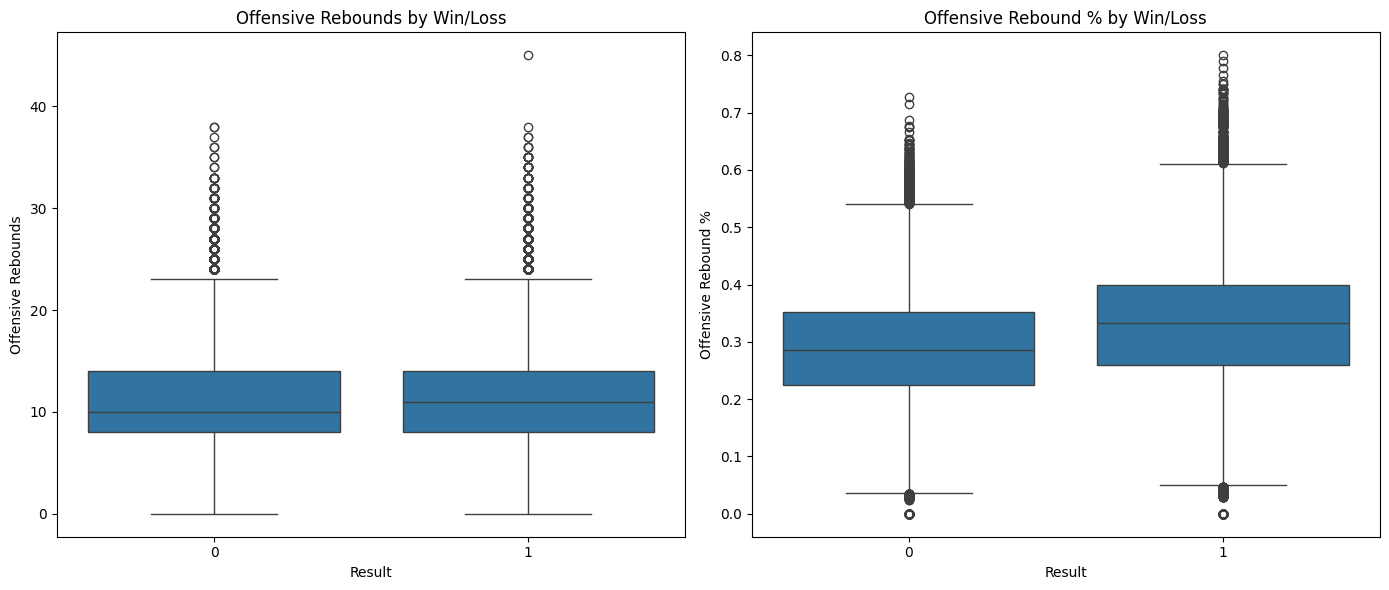

In [26]:
# Set up side-by-side boxplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Chart D: Boxplot of OR by Win/Loss
sns.boxplot(data=to_make_graphs, x='Win', y='OR', ax=axes[0])
axes[0].set_title('Offensive Rebounds by Win/Loss')
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Offensive Rebounds')

# Chart E: Boxplot of OR% by Win/Loss
sns.boxplot(data=to_make_graphs, x='Win', y='ORPercent', ax=axes[1])
axes[1].set_title('Offensive Rebound % by Win/Loss')
axes[1].set_xlabel('Result')
axes[1].set_ylabel('Offensive Rebound %')

plt.tight_layout()
plt.show()

In [34]:
to_make_graphs["AstPerPoss"]    = safe_divide(games_expanded_detailed["Ast"],   games_expanded_detailed["Possessions"])
to_make_graphs["OppAstPerPoss"]    = safe_divide(games_expanded_detailed["OppAst"],   games_expanded_detailed["OppPossessions"])

to_make_graphs["AstPerPossDiff"] = to_make_graphs["AstPerPoss"] - to_make_graphs["OppAstPerPoss"]
to_make_graphs["AstPercentDiff"] = to_make_graphs["AstPercent"] - to_make_graphs["OppAstPercent"]
to_make_graphs["AstDiff"] = to_make_graphs["Ast"] - to_make_graphs["OppAst"]


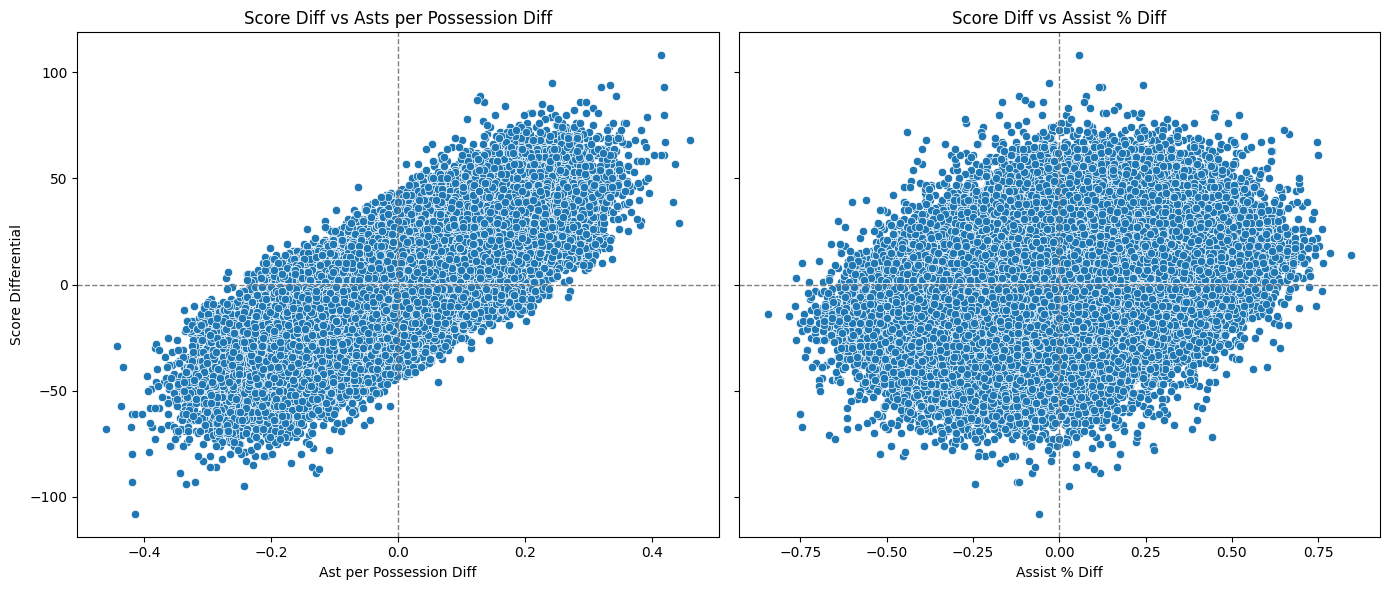

In [35]:
# Set up side-by-side scatterplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: AstPerPossDiff vs ScoreDiff
sns.scatterplot(data=to_make_graphs, x='AstPerPossDiff', y='ScoreDiff', ax=axes[0])
axes[0].set_title('Score Diff vs Asts per Possession Diff')
axes[0].set_xlabel('Ast per Possession Diff')
axes[0].set_ylabel('Score Differential')
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0].axvline(0, color='gray', linestyle='--', linewidth=1)

# Plot 2: AstPercentDiff vs ScoreDiff
sns.scatterplot(data=to_make_graphs, x='AstPercentDiff', y='ScoreDiff', ax=axes[1])
axes[1].set_title('Score Diff vs Assist % Diff')
axes[1].set_xlabel('Assist % Diff')
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].axvline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

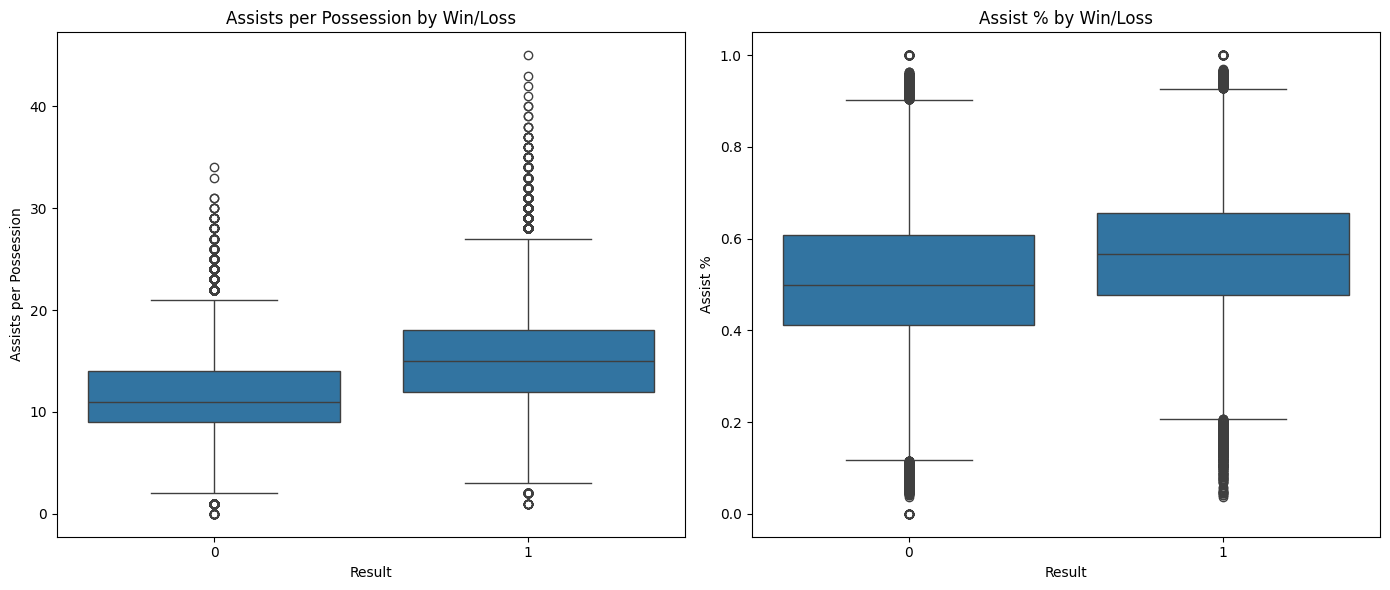

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Chart A: Boxplot of AstPerPoss by Win/Loss
sns.boxplot(data=to_make_graphs, x='Win', y='Ast', ax=axes[0])
axes[0].set_title('Assists per Possession by Win/Loss')
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Assists per Possession')

# Chart B: Boxplot of AstPercent by Win/Loss
sns.boxplot(data=to_make_graphs, x='Win', y='AstPercent', ax=axes[1])
axes[1].set_title('Assist % by Win/Loss')
axes[1].set_xlabel('Result')
axes[1].set_ylabel('Assist %')

plt.tight_layout()
plt.show()

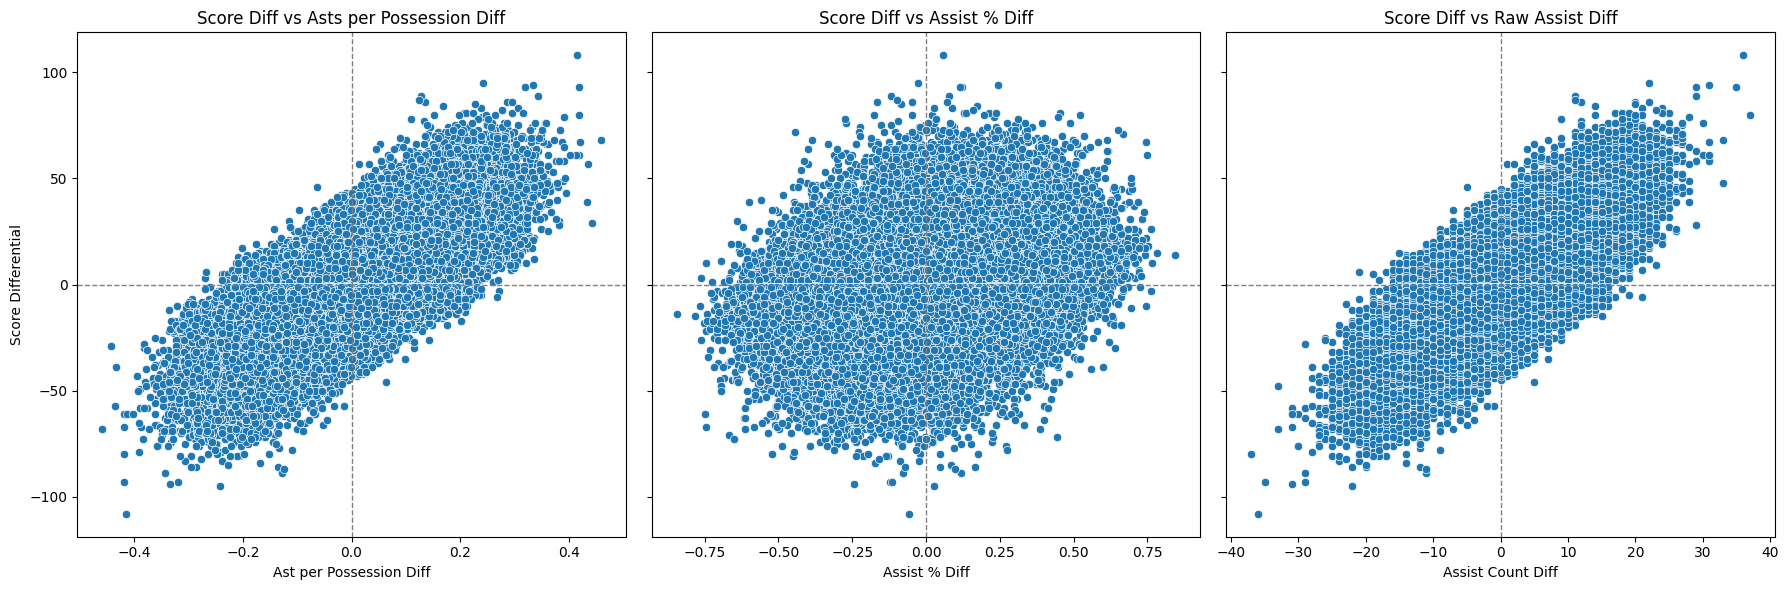

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot 1: AstPerPossDiff vs ScoreDiff
sns.scatterplot(data=to_make_graphs, x='AstPerPossDiff', y='ScoreDiff', ax=axes[0])
axes[0].set_title('Score Diff vs Asts per Possession Diff')
axes[0].set_xlabel('Ast per Possession Diff')
axes[0].set_ylabel('Score Differential')
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0].axvline(0, color='gray', linestyle='--', linewidth=1)

# Plot 2: AstPercentDiff vs ScoreDiff
sns.scatterplot(data=to_make_graphs, x='AstPercentDiff', y='ScoreDiff', ax=axes[1])
axes[1].set_title('Score Diff vs Assist % Diff')
axes[1].set_xlabel('Assist % Diff')
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].axvline(0, color='gray', linestyle='--', linewidth=1)

# Plot 3: AstDiff vs ScoreDiff
sns.scatterplot(data=to_make_graphs, x='AstDiff', y='ScoreDiff', ax=axes[2])
axes[2].set_title('Score Diff vs Raw Assist Diff')
axes[2].set_xlabel('Assist Count Diff')
axes[2].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[2].axvline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

/var/folders/nx/9q47sdzn7rd9vcwgb2h8jhhc0000gn/T/ipykernel_86464/3342188964.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Loss', 'Win'])
/var/folders/nx/9q47sdzn7rd9vcwgb2h8jhhc0000gn/T/ipykernel_86464/3342188964.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Loss', 'Win'])
/var/folders/nx/9q47sdzn7rd9vcwgb2h8jhhc0000gn/T/ipykernel_86464/3342188964.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(['Loss', 'Win'])


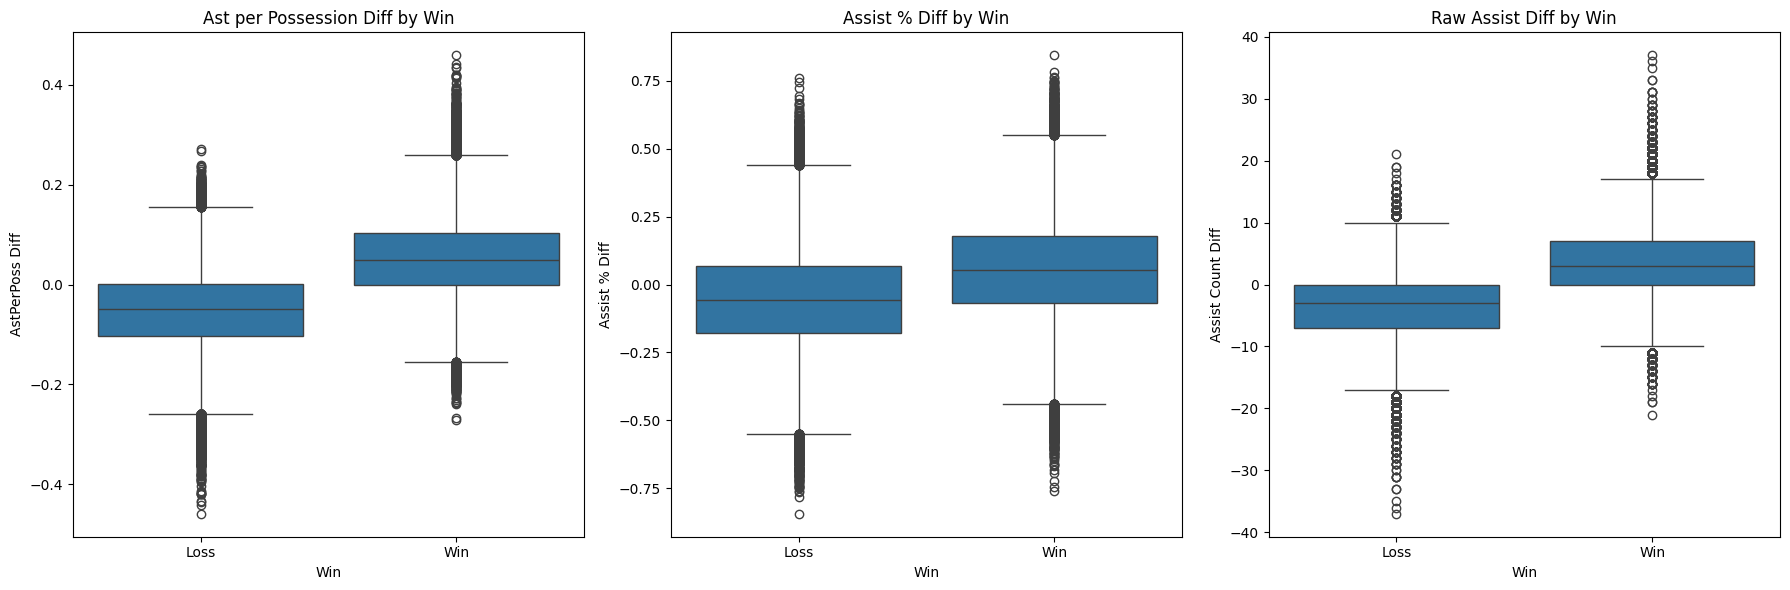

In [37]:
to_make_graphs['Win'] = to_make_graphs['ScoreDiff'] > 0

# Set up 3 boxplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Chart 1: AstPerPossDiff
sns.boxplot(data=to_make_graphs, x='Win', y='AstPerPossDiff', ax=axes[0])
axes[0].set_title('Ast per Possession Diff by Win')
axes[0].set_xlabel('Win')
axes[0].set_ylabel('AstPerPoss Diff')
axes[0].set_xticklabels(['Loss', 'Win'])

# Chart 2: AstPercentDiff
sns.boxplot(data=to_make_graphs, x='Win', y='AstPercentDiff', ax=axes[1])
axes[1].set_title('Assist % Diff by Win')
axes[1].set_xlabel('Win')
axes[1].set_ylabel('Assist % Diff')
axes[1].set_xticklabels(['Loss', 'Win'])

# Chart 3: AstDiff
sns.boxplot(data=to_make_graphs, x='Win', y='AstDiff', ax=axes[2])
axes[2].set_title('Raw Assist Diff by Win')
axes[2].set_xlabel('Win')
axes[2].set_ylabel('Assist Count Diff')
axes[2].set_xticklabels(['Loss', 'Win'])

plt.tight_layout()
plt.show()

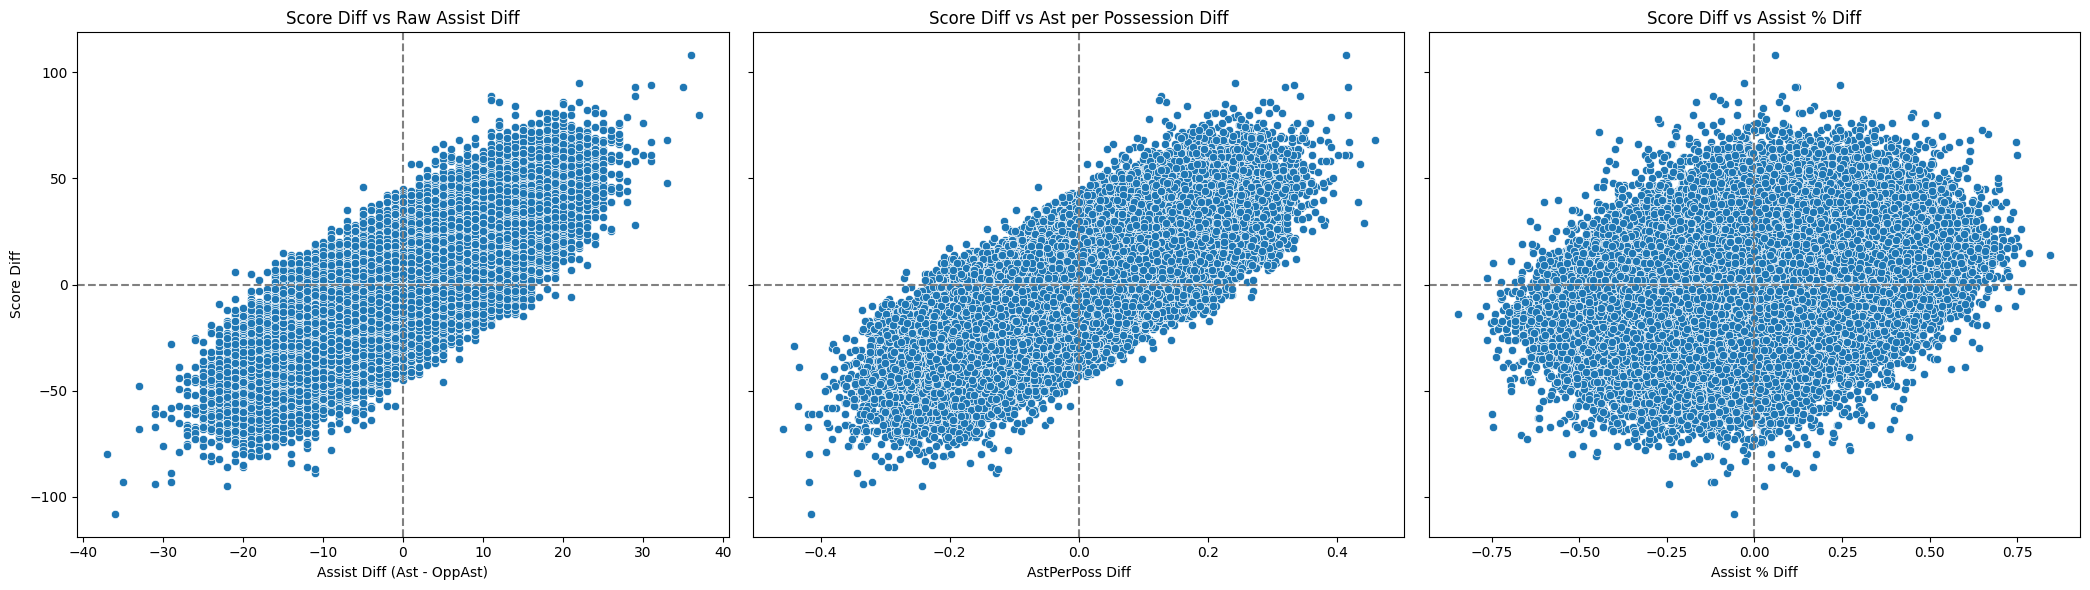

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True)

# Chart 1: Raw Ast Diff
sns.scatterplot(data=to_make_graphs, x='AstDiff', y='ScoreDiff', ax=axes[0])
axes[0].set_title('Score Diff vs Raw Assist Diff')
axes[0].set_xlabel('Assist Diff (Ast - OppAst)')
axes[0].set_ylabel('Score Diff')
axes[0].axhline(0, color='gray', linestyle='--')
axes[0].axvline(0, color='gray', linestyle='--')

# Chart 2: Ast per Poss Diff
sns.scatterplot(data=to_make_graphs, x='AstPerPossDiff', y='ScoreDiff', ax=axes[1])
axes[1].set_title('Score Diff vs Ast per Possession Diff')
axes[1].set_xlabel('AstPerPoss Diff')
axes[1].set_ylabel('')
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].axvline(0, color='gray', linestyle='--')

# Chart 3: Assist Percent Diff
sns.scatterplot(data=to_make_graphs, x='AstPercentDiff', y='ScoreDiff', ax=axes[2])
axes[2].set_title('Score Diff vs Assist % Diff')
axes[2].set_xlabel('Assist % Diff')
axes[2].set_ylabel('')
axes[2].axhline(0, color='gray', linestyle='--')
axes[2].axvline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

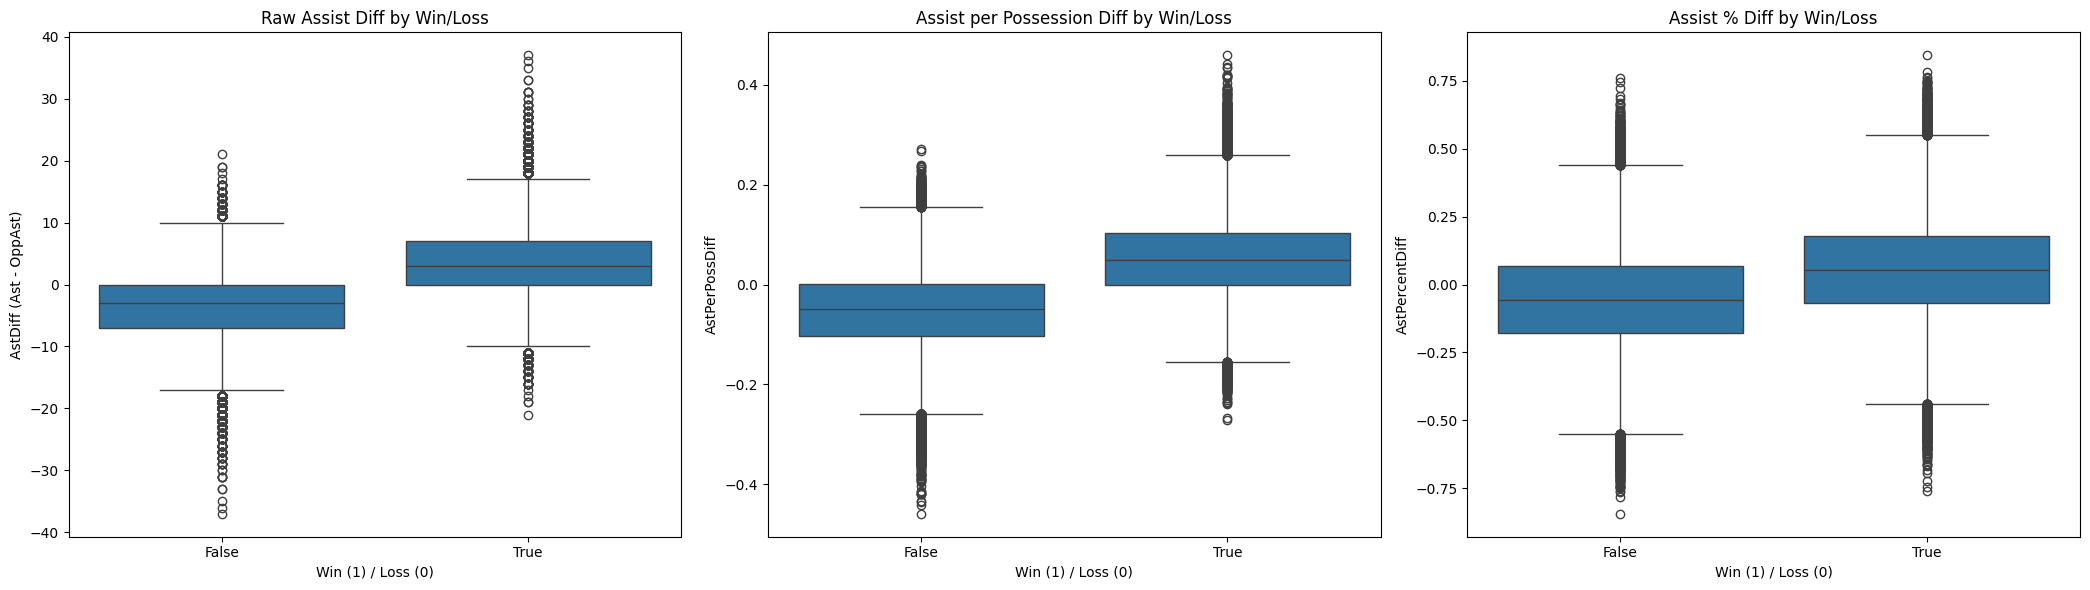

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Chart 1: Raw Assist Diff
sns.boxplot(data=to_make_graphs, x='Win', y='AstDiff', ax=axes[0])
axes[0].set_title('Raw Assist Diff by Win/Loss')
axes[0].set_xlabel('Win (1) / Loss (0)')
axes[0].set_ylabel('AstDiff (Ast - OppAst)')

# Chart 2: Ast per Possession Diff
sns.boxplot(data=to_make_graphs, x='Win', y='AstPerPossDiff', ax=axes[1])
axes[1].set_title('Assist per Possession Diff by Win/Loss')
axes[1].set_xlabel('Win (1) / Loss (0)')
axes[1].set_ylabel('AstPerPossDiff')

# Chart 3: Assist % Diff
sns.boxplot(data=to_make_graphs, x='Win', y='AstPercentDiff', ax=axes[2])
axes[2].set_title('Assist % Diff by Win/Loss')
axes[2].set_xlabel('Win (1) / Loss (0)')
axes[2].set_ylabel('AstPercentDiff')

plt.tight_layout()
plt.show()